In [21]:
import numpy as np
import pandas as pd
import polars as pl
import marshal, json
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches as patches
from matplotlib import cm
import matplotlib
import json, math
from operator import sub
import scipy.stats
from IPython.display import set_matplotlib_formats
from IPython.display import Image
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.latex.preamble': r'\usepackage{amsmath}'
})

In [22]:
v = 44
n = 100
i_rdf = 120
q = 0

plot_traces = False


In [23]:
def get_num_possible_receivers(row, positions): 
    x0 = row['pos_x']
    y0 = row['pos_y']
    ts = row['timestamp']
    positions = positions.copy()
    positions_now = positions.query(f'timestamp == {ts}')
    positions_now['dist'] = np.sqrt(np.power(positions_now['pos_x'] -x0, 2) + np.power(positions_now['pos_y'] -y0, 2))
    valid_positions = positions_now[positions_now['dist'] <= 509.8]
    # print(row['num_receivers'] / (len(valid_positions) -1) ,len(positions), len(positions_now), row['num_receivers'], len(valid_positions) -1, row['seqNo'])
    return len(valid_positions)

def get_augmented_events(nodeId, events, positions):
    events = events[events['timestamp'] >= 5.0]
    events = events.query(f'nodeId == {nodeId} | src == {nodeId}')

    nodeIds = events['nodeId'].unique()
    positions = positions[positions['nodeId'].isin(nodeIds)]

    #event_positions = events[['nodeId','timestamp']]
    # positions = pd.concat([positions, event_positions]).sort_values('timestamp').reset_index(drop=True).drop_duplicates()
    # positions = positions.groupby('nodeId', group_keys=False).apply(lambda group: group.interpolate())
    
    event_times = events.loc[:,['timestamp']].drop_duplicates()
    positions = positions.groupby('nodeId', group_keys=False).apply(lambda group: pd.concat([group, event_times]).sort_values('timestamp').reset_index(drop=True).interpolate())
    
    if len(events) * len(positions) == 0:
        return pd.DataFrame([])
        
    events = pd.merge(events, positions, how='inner', on=['nodeId','timestamp'])

    sent_events = events.query('eventType == "PktSent"')
    received_events = events.query('eventType == "PktRcvd" & numHops == 0')
    received_count = received_events['seqNo'].value_counts().rename_axis('seqNo').to_frame('num_receivers')
    sent_events = sent_events.join(received_count, how='inner', on='seqNo')


    sent_events['num_possible_receivers'] = sent_events.apply(lambda row: get_num_possible_receivers(row, positions), axis=1)
    return sent_events

In [24]:
parsed_sent_events = pd.DataFrame([])
for r in range(5):
    rdf_events = pd.read_csv(f'../res/v{v}/rdf_n{n}_i{i_rdf}_q{q}_r{r}.csv')
    rdf_positions = pd.read_csv(f'../res/v{v}/course_rdf_n{n}_i{i_rdf}_q{q}_r{r}.csv')

    for i in range(1, n):
        parsed_sent_events = pd.concat([parsed_sent_events, get_augmented_events(i, rdf_events.copy(), rdf_positions.copy())])
        print(r, i, len(parsed_sent_events))

0 1 278
0 2 577
0 3 858
0 4 1137
0 5 1443
0 6 1718
0 7 2008
0 8 2318
0 9 2574
0 10 2866
0 11 3161
0 12 3460
0 13 3734
0 14 4021
0 15 4325
0 16 4614
0 17 4903
0 18 5202
0 19 5477
0 20 5770
0 21 6065
0 22 6364
0 23 6665
0 24 6961
0 25 7261
0 26 7563
0 27 7846
0 28 8150
0 29 8420
0 30 8674
0 31 8977
0 32 9278
0 33 9559
0 34 9782
0 35 10084
0 36 10382
0 37 10688
0 38 10973
0 39 11271
0 40 11551
0 41 11815
0 42 12120
0 43 12407
0 44 12714
0 45 12955
0 46 13237
0 47 13531
0 48 13804
0 49 14106
0 50 14377
0 51 14661
0 52 14933
0 53 15228
0 54 15515
0 55 15806
0 56 16093
0 57 16329
0 58 16630
0 59 16915
0 60 17206
0 61 17507
0 62 17807
0 63 18093
0 64 18365
0 65 18667
0 66 18952
0 67 19247
0 68 19488
0 69 19782
0 70 20075
0 71 20362
0 72 20639
0 73 20941
0 74 21223
0 75 21510
0 76 21816
0 77 22115
0 78 22404
0 79 22672
0 80 22965
0 81 23258
0 82 23556
0 83 23855
0 84 24147
0 85 24435
0 86 24740
0 87 25026
0 88 25278
0 89 25581
0 90 25857
0 91 26147
0 92 26434
0 93 26740
0 94 27032
0 95 27321
0

KeyboardInterrupt: 

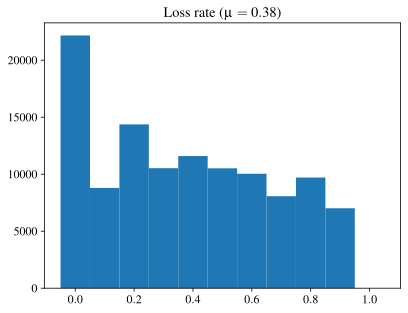

In [25]:

fig, ax = plt.subplots()
reception_rates = np.array(parsed_sent_events['num_receivers']) / np.array(parsed_sent_events['num_possible_receivers'] - 1)
step_size = 0.1
ax.hist(1-reception_rates, bins= np.arange(-step_size /2, 1 + step_size, step_size))

plt.title(f'Loss rate ($\mu = {1-np.mean(reception_rates):.2f}$)')
fig.savefig(f"../figures/loss_rate_dist_n{n}_q{q}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/loss_rate_dist_n{n}_q{q}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)
plt.show()


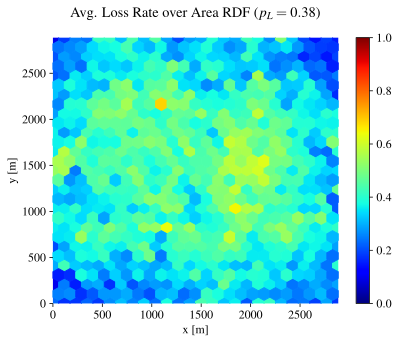

In [26]:
size = math.sqrt(n / 12) * 1000
fig, ax = plt.subplots()
im = ax.hexbin(
    parsed_sent_events['pos_x'], 
    parsed_sent_events['pos_y'], 
    C=1-reception_rates, 
    vmin=0,
    vmax=1,
    gridsize=25,
    clip_on=True,
    cmap=cm.jet
)

#ax.axis(False)
ax.set_ylim([0,size])
ax.set_xlim([0,size])
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.title(f'Avg. Loss Rate over Area RDF ($p_L = {1-np.mean(reception_rates):.2f}$)\n')
plt.colorbar(im)

fig.savefig(f"../figures/loss_rate_area_n{n}_q{q}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/loss_rate_area_n{n}_q{q}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

plt.show()

In [ ]:
print(reception_rates)

[0.33333333 0.30769231 0.69230769 0.84615385 0.15384615 0.84615385
 0.61538462 0.61538462 0.61538462 0.23076923 0.69230769 0.76923077
 0.61538462 0.84615385 0.84615385 0.61538462 0.76923077 0.23076923
 0.76923077 0.75       0.08333333 0.66666667 1.         0.75
 0.75       1.         0.75       0.16666667 0.72727273 0.72727273
 1.         0.72727273 0.90909091 0.72727273 0.72727273 0.72727273
 0.90909091 0.81818182 0.27272727 0.81818182 0.81818182 0.36363636
 1.         0.81818182 0.72727273 0.81818182 0.90909091 1.
 0.72727273 1.         0.90909091 1.         1.         1.
 0.72727273 1.         0.72727273 1.         0.90909091 1.
 1.         1.         0.90909091 0.90909091 0.72727273 0.72727273
 0.72727273 1.         1.         1.         0.45454545 0.72727273
 1.         0.91666667 0.90909091 1.         0.6        0.5
 0.1        0.8        0.6        0.9        0.8        1.
 0.55555556 0.11111111 1.         1.         0.77777778 0.88888889
 0.2        0.90909091 0.4        0.6   